First, we install the [flow-stability](https://github.com/alexbovet/flow_stability) package:

In [ ]:
!pip install sparse_dot_mkl  # this is optional
!pip install git+https://github.com/alexbovet/flow_stability.git

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from flowstab.synth_temp_network import Individual, SynthTempNetwork
from flowstab.temporal_network import ContTempNetwork
from flowstab.flow_stability import FlowIntegralClustering

MKL_INT_NUMPY <class 'numpy.int32'>


# Example of temporal network with asymmetric temporal paths (Fig. 2)


In [2]:
inter_tau = 1
activ_tau = 1
t_start = 0
n_groups = 3
n_per_group = 9
individuals = []


m1=0.95
p1=0.95
deltat1 =120
deltat2=40

t_end = 3*deltat1+2*deltat2




def make_step_block_probs(deltat1, deltat2, m1=1, p1=1):
    """ Returns a function that generate the block probability matrix as a function of time.
    
        `deltat1` is the length of the within step
    
        `deltat2` is the length of the echanging step
        
        `m1` is the prob of self-interaction (during deltat1)
        
        `p1` is the prob of cross-interaction (during deltat2)
    """


    def block_mod_func(t):
        
        m2 = (1-m1)/2
        p2 = (1-p1)
        
        ex12 = np.array([[p2,p1,0],
                         [p1,p2,0],
                         [0,0,1]])
        ex23 = np.array([[1,0,0],
                         [0,p2,p1],
                         [0,p1,p2]])
        ex13 = np.array([[p2,0,p1],
                         [0, 1, 0],
                         [p1,0,p2]])
    
        I = np.array([[m1,m2,m2],
                      [m2,m1,m2],
                      [m2,m2,m1]])
        if t>=0 and  t < deltat1:
            return ex12
        elif t>=deltat1 and t<deltat1+deltat2:
            return I
        elif t>=deltat1+deltat2 and t < 2*deltat1+deltat2:
            return ex23
        elif t>= 2*deltat1+deltat2 and t < 2*(deltat1+deltat2):
            return I
        elif t>= 2*(deltat1+deltat2) and t < 2*(deltat1+deltat2)+deltat1:
            return ex13
        else:
            print('Warning : t must be >=0 and <= 3*deltat1+2*deltat2' +\
                  't is ', t)
            return I
        
    return block_mod_func
 


block_prob_mod_func = make_step_block_probs(deltat1,deltat2,m1,p1)


In [3]:
# create agents for the simlation
for g in range(n_groups):

    individuals.extend([Individual(i, inter_distro_scale=inter_tau,
                                      activ_distro_scale=activ_tau,
                                      group=g) for i in range(g*n_per_group,(g+1)*n_per_group)])

In [4]:
# run simulation
sim = SynthTempNetwork(individuals=individuals, t_start=t_start, t_end=t_end,
                       next_event_method='block_probs_mod',
                       block_prob_mod_func=block_prob_mod_func)

print('running simulation')
t0 = time.time()
sim.run(save_all_states=True, save_dt_states=True, verbose=False)
print(f'done in {time.time()-t0:.2f}s')


running simulation
done in 10.58s


## Creating a continuous time temporal network

In [5]:
# creating a temporal network from the simulation's result
net = ContTempNetwork(source_nodes=sim.indiv_sources,
                      target_nodes=sim.indiv_targets,
                      starting_times=sim.start_times,
                      ending_times=sim.end_times,
                      merge_overlapping_events=True)

PID  1491567  :  merged  1216  events
PID  1491567  :  merged  0  events


In [6]:
# the events of the temporal network are saved in a pandas dataframe in net.events_table
net.events_table

,source_nodes,target_nodes,starting_times,ending_times,durations
0,7,14,0.038237,0.385598,0.347361
1,6,15,0.105385,1.367475,1.262090
2,2,11,0.151528,1.785403,1.633875
3,20,18,0.236481,1.085770,0.849289
4,12,0,0.249590,0.739063,0.489474
...,...,...,...,...,...
10440,22,0,439.440735,439.469266,0.028531
10441,11,14,439.467442,439.968364,0.500922
10442,26,7,439.627700,439.921223,0.293523
10443,1,18,439.702696,439.868876,0.166180


In [7]:
# all the event times (starts and ends) are saved in 
net.times

Index([0.03823699118666961, 0.10538517876640334, 0.15152810321263793,
       0.23648094698991404, 0.24958964049813093, 0.26037798310043053,
       0.26304951931514253,  0.3027661852536156,  0.3271930537952775,
       0.36060545657625076,
       ...
         439.8301049509316,   439.8426586818743,   439.8638814470383,
         439.8688764739943,   439.8987432322119,  439.91036055093286,
         439.9138148040421,   439.9212225252944,  439.93858888742886,
         439.9683639663683],
      dtype='float64', name='times', length=20890)

In [8]:
# Compute inter transition matrices. 
# lamda is random walk rate.
# By default, the matrix exponential is computed using the version of the algorithm for dense matrices (scipy expm), 
# which is faster but only works for small networks. 
# To use the sparse implementation, set `dense_expm=False`

lamda=1/10
t0 = time.time()
net.compute_inter_transition_matrices(lamda=lamda, verbose=True)
print(f'done in {time.time()-t0:.2f}s')

PID  1491567  :  Computing Laplacians
PID  1491567  :  0  over  20889
PID 1491567 : 0.01s
PID  1491567  :  1000  over  20889
PID 1491567 : 1.70s
PID  1491567  :  2000  over  20889
PID 1491567 : 3.88s
PID  1491567  :  3000  over  20889
PID 1491567 : 5.48s
PID  1491567  :  4000  over  20889
PID 1491567 : 7.14s
PID  1491567  :  5000  over  20889
PID 1491567 : 8.60s
PID  1491567  :  6000  over  20889
PID 1491567 : 10.43s
PID  1491567  :  7000  over  20889
PID 1491567 : 11.92s
PID  1491567  :  8000  over  20889
PID 1491567 : 13.20s
PID  1491567  :  9000  over  20889
PID 1491567 : 14.95s
PID  1491567  :  10000  over  20889
PID 1491567 : 16.44s
PID  1491567  :  11000  over  20889
PID 1491567 : 18.01s
PID  1491567  :  12000  over  20889
PID 1491567 : 19.39s
PID  1491567  :  13000  over  20889
PID 1491567 : 20.76s
PID  1491567  :  14000  over  20889
PID 1491567 : 22.25s
PID  1491567  :  15000  over  20889
PID 1491567 : 23.75s
PID  1491567  :  16000  over  20889
PID 1491567 : 25.04s
PID  1491567

In [9]:
# the matrices are saved in a list here
net.inter_T[lamda]
# where net.inter_T[lamda][k] is the probability transition matrix
# between net.times[k] and net.times[k+1]

[<27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 29 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 31 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 33 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 35 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 37 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 39 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 37 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 41 stored elements in Compressed Sparse Row format>,
 <27x27 sparse matrix of type '<class 'numpy.float64'>'
 	with 45 stored

In [10]:
# the temporal network can be saved, togheter with the inter-event transition matrices in a pickle file:
net.save('example_network')


In [11]:
# and can be loaded unsing `ContTempNetwork.load`
net2 = ContTempNetwork.load('example_network')


## Computing the covariance integral

In [12]:
# We can now compute the integral of the covariance using FlowIntegralClustering.
# We need to give the inter-event transition matrices, the inter-event times and 
# a list of times until which to compute the integral is computed.

integral_time_grid = np.linspace(0, t_end, 12, endpoint=True)

I_forw = FlowIntegralClustering(T_inter_list=[T.toarray() for T in net.inter_T[lamda]], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                verbose=True)

PID  1491567  : computing T_list
PID  1491567  : computing integral
PID  1491567  :  0  over  20889  took 0.00s
PID  1491567  :  1000  over  20889  took 0.04s
PID  1491567  :  2000  over  20889  took 0.03s
PID  1491567  :  3000  over  20889  took 0.03s
PID  1491567  :  4000  over  20889  took 0.03s
PID  1491567  :  5000  over  20889  took 0.03s
PID  1491567  :  6000  over  20889  took 0.03s
PID  1491567  :  7000  over  20889  took 0.04s
PID  1491567  :  8000  over  20889  took 0.03s
PID  1491567  :  9000  over  20889  took 0.03s
PID  1491567  :  10000  over  20889  took 0.03s
PID  1491567  :  11000  over  20889  took 0.03s
PID  1491567  :  12000  over  20889  took 0.04s
PID  1491567  :  13000  over  20889  took 0.04s
PID  1491567  :  14000  over  20889  took 0.04s
PID  1491567  :  15000  over  20889  took 0.03s
PID  1491567  :  16000  over  20889  took 0.03s
PID  1491567  :  17000  over  20889  took 0.03s
PID  1491567  :  18000  over  20889  took 0.03s
PID  1491567  :  19000  over  208

In [13]:
# The list of transition matrices are stored in I_forw.T_list
# where I_forw.T_list[k] contains the transition matrix between net.times[0] and net.times[k+1]

I_forw.T_list[10]

array([[9.87809457e-01, 1.68733308e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.26180509e-03, 0.00000000e+00, 0.00000000e+00,
        9.92705036e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.93800620e-08, 9.99657217e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.67892871e-12, 0.00000000e+00, 0.00000000e+00,
        3.42753501e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00

In [14]:
# The autocovariance integrals are stored in I_forw.I_list
# I_forw.I_list[k] contains the integral of the autocovariance 
# from I_forw._t_integral_grid[0] to I_forw._t_integral_grid[k+1]

I_forw.I_list[3]

array([[ 0.00199254,  0.0005497 ,  0.00053039,  0.00057808,  0.00052343,
         0.00052438,  0.00055056,  0.00056722,  0.00052609,  0.00057178,
         0.0005602 ,  0.00078289,  0.00065327,  0.00062927,  0.00068435,
         0.00051872,  0.00058359,  0.00047167, -0.0013109 , -0.0013109 ,
        -0.0013109 , -0.0013109 , -0.0013109 , -0.0013109 , -0.0013109 ,
        -0.0013109 , -0.0013109 ],
       [ 0.0005497 ,  0.00189853,  0.00056715,  0.00054773,  0.00062653,
         0.00051191,  0.00052868,  0.00053072,  0.00052535,  0.00052614,
         0.00053039,  0.00057836,  0.00092325,  0.00058087,  0.00048893,
         0.000663  ,  0.00062525,  0.00059567, -0.00131091, -0.00131091,
        -0.00131091, -0.00131091, -0.00131091, -0.00131091, -0.00131091,
        -0.00131091, -0.00131091],
       [ 0.00053039,  0.00056715,  0.00203178,  0.00053535,  0.00051705,
         0.00047554,  0.00053901,  0.00056065,  0.00052551,  0.00059656,
         0.00064404,  0.00067489,  0.00076201,  0.0007

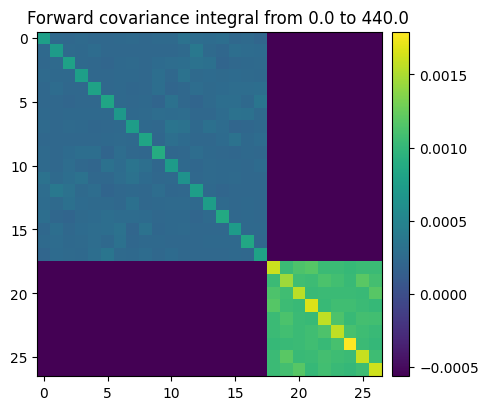

In [15]:
plt.matshow(I_forw.I_list[10])
ax = plt.gca()
adivider = make_axes_locatable(ax)
cax = adivider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
ax.xaxis.tick_bottom()
_ =  plt.title(f'Forward covariance integral from {I_forw.integral_time_grid[0]} to {I_forw.integral_time_grid[11]}',
               loc='right')


In [16]:
# similarly, we can compute the backward covariance integral, by reversing time.
I_back = FlowIntegralClustering(T_inter_list=[T.toarray() for T in net.inter_T[lamda]], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                reverse_time=True,
                                verbose=True)

PID  1491567  : computing T_list
PID  1491567  : computing integral
PID  1491567  :  0  over  20889  took 0.00s
PID  1491567  :  1000  over  20889  took 0.03s
PID  1491567  :  2000  over  20889  took 0.04s
PID  1491567  :  3000  over  20889  took 0.03s
PID  1491567  :  4000  over  20889  took 0.03s
PID  1491567  :  5000  over  20889  took 0.03s
PID  1491567  :  6000  over  20889  took 0.04s
PID  1491567  :  7000  over  20889  took 0.04s
PID  1491567  :  8000  over  20889  took 0.04s
PID  1491567  :  9000  over  20889  took 0.04s
PID  1491567  :  10000  over  20889  took 0.07s
PID  1491567  :  11000  over  20889  took 0.04s
PID  1491567  :  12000  over  20889  took 0.04s
PID  1491567  :  13000  over  20889  took 0.05s
PID  1491567  :  14000  over  20889  took 0.04s
PID  1491567  :  15000  over  20889  took 0.04s
PID  1491567  :  16000  over  20889  took 0.03s
PID  1491567  :  17000  over  20889  took 0.04s
PID  1491567  :  18000  over  20889  took 0.03s
PID  1491567  :  19000  over  208

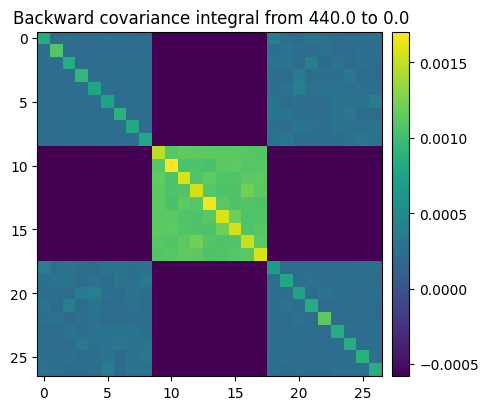

In [17]:
plt.matshow(I_back.I_list[10])
ax = plt.gca()
adivider = make_axes_locatable(ax)
cax = adivider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
ax.xaxis.tick_bottom()
_ = plt.title(f'Backward covariance integral from {I_back.integral_time_grid[0]} to {I_back.integral_time_grid[11]}',
              loc='right')


## Optimizing the flow stability to find the best partition

In [18]:
# we can now find the partition optimizing the flow stability, 
# i.e. best clustering the covariance integral, with the Louvain algorithm
I_forw.find_louvain_clustering(k=10)

2

In [19]:
# the result is saved in 
I_forw.partition[10]
# and is a `Partition` object 

Partition with 27 nodes and 2 clusters.

In [20]:
# the cluster list is stored in 
I_forw.partition[10].cluster_list

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17},
 {18, 19, 20, 21, 22, 23, 24, 25, 26}]

In [21]:
# a dictionary mapping node ids to cluster ids is also availiable
I_forw.partition[10].node_to_cluster_dict

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1}

In [22]:
# Similarly for the backward flow stability
I_back.find_louvain_clustering(k=10)


2

In [23]:
I_back.partition[10].cluster_list

[{9, 10, 11, 12, 13, 14, 15, 16, 17},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26}]